# roAp Classification using regression techniques with K-Nearest-Neighbors (KNN):

### Updates:
        initial: (03/2/2023)

In [21]:
from sklearn import neighbors, datasets, preprocessing, linear_model
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import gaussian_kde

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### 1. Importing csv files containing NGC 2264 and known roAps
        'roAp' is the csv file including the field roAps
        'clust' is the csv file including NGC 2264 cluster stars 

In [22]:
r = pd.read_csv('Data/field_roAp.csv', index_col=False)
c = pd.read_csv('Data/15MON_A0_FOV.csv', index_col=False)
rfeat = r.columns
cfeat = c.columns

roAp = pd.DataFrame(r)
clust = pd.DataFrame(c)
dbr = np.append(np.array(roAp), np.array(roAp), axis=1)
dbc = np.append(np.array(clust), np.array(clust), axis=1)
# Concatenating datasets to find roAp condidates in NGC 2264
all = pd.concat([roAp, clust],axis=0)
all['designation'] = all['designation'].str.replace(r'\D', '')
db = np.append(np.array(all),np.array(all),axis=1)
# Extracting features of all datasets
yr = (roAp['GMAG0']).values
yc = (clust['GMAG0']).values
xr = (roAp['BP-RP0']).values
xc = (clust['BP-RP0']).values
y = (all['GMAG0']).values
x = (all['BP-RP0']).values

print('Features:', len(yr))
print('Target:', len(yc))
print('---------')
print('Total Dataset for field roAps:', dbr.data.shape)
print('Total Dataset for NGC 2264:', dbc.data.shape)
print('Concatenated Dataset:',all.shape)
all.describe()

/tmp/ipykernel_15590/1649100.py:12: FutureWarning: The default value of regex will change from True to False in a future version.
  all['designation'] = all['designation'].str.replace(r'\D', '')


Features: 93
Target: 965
---------
Total Dataset for field roAps: (93, 120)
Total Dataset for NGC 2264: (965, 172)
Concatenated Dataset: (1058, 90)


,num,id,ra,RA_ICRS,dec,DE_ICRS,GMAG0,BP-RP0,ecl_lon,ecl_lat,...,grvs_mag,grvs_mag_error,logg_gspphot,mh_gspphot,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_g_mean_flux,phot_g_mean_flux_error,phot_rp_mean_flux,phot_rp_mean_flux_error
count,1058.000000,1058.000000,1058.000000,1058.000000,1058.000000,1058.000000,1058.000000,1058.000000,1058.000000,1058.000000,...,127.000000,127.000000,846.000000,846.000000,9.650000e+02,965.000000,9.650000e+02,965.000000,9.650000e+02,965.000000
mean,0.087902,528.500000,109.151299,109.151289,7.478114,7.478106,3.442366,0.757858,109.771502,-13.118243,...,12.503708,0.073577,4.376956,-1.251781,2.165922e+04,74.888334,4.196140e+04,21.822412,2.990228e+04,77.776609
std,0.283286,305.562596,41.211886,41.211825,13.838901,13.838930,2.109317,0.467252,42.045784,12.764718,...,1.210838,0.063511,0.459858,1.033316,1.807347e+05,1115.473325,3.672976e+05,110.827438,2.778614e+05,1033.807892
min,0.000000,0.000000,2.127157,2.127157,-81.902104,-81.902104,-2.724406,-0.274474,2.019759,-85.377605,...,7.257843,0.005903,1.560400,-4.080400,9.493662e+01,5.431366,7.524995e+02,1.351323,7.388467e+02,6.360226
25%,0.000000,264.250000,100.119403,100.119403,9.797506,9.797506,2.154758,0.536962,100.236203,-13.265848,...,12.066604,0.029815,4.194500,-1.636250,3.390643e+02,11.071645,1.269774e+03,2.042505,1.384733e+03,12.372756
50%,0.000000,528.500000,100.244704,100.244704,9.920538,9.920538,3.409107,0.713893,100.364398,-13.137302,...,12.808246,0.062369,4.455300,-1.098800,6.898837e+02,14.236284,2.602011e+03,2.892261,2.781346e+03,15.658791
75%,0.000000,792.750000,100.431403,100.431403,10.019111,10.019111,4.361791,0.921099,100.558289,-13.049704,...,13.332334,0.105035,4.713975,-0.429025,2.274583e+03,20.523827,7.898782e+03,6.651048,8.173050e+03,24.481014
max,1.000000,1057.000000,348.317184,348.305087,58.526905,58.526905,13.284124,3.569711,336.146049,69.335987,...,14.090522,0.507102,5.158000,0.635400,4.076147e+06,34367.074000,9.490580e+06,2162.942900,7.721012e+06,31803.912000


#### Plotting the initial HRD with the field roAps and NGC 2264

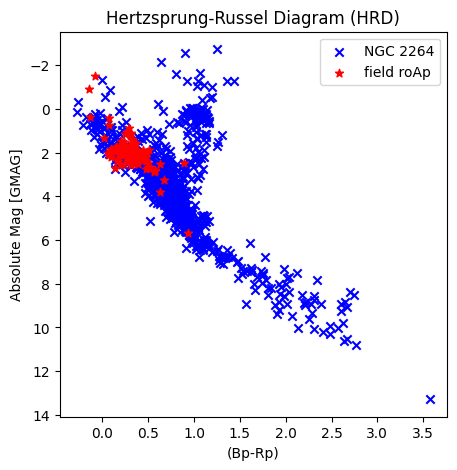

In [23]:
plt.figure(figsize=(5,5))
plt.scatter(x=xc,y=yc,marker='x', c='b', label='NGC 2264')
plt.scatter(x=xr,y=yr,marker='*', c='r', label='field roAp')
plt.legend()
plt.title('Hertzsprung-Russel Diagram (HRD)')
plt.ylabel('Absolute Mag [GMAG]')
plt.xlabel('(Bp-Rp)')
plt.gca().invert_yaxis()

### 2. Splitting the data to be used for training and showing the sizes

In [24]:
column = 0

# Splitting data 80:20

xtrain, xtest, ytrain, ytest = train_test_split(db[:,np.newaxis,8],
                                                db[:,7],train_size=0.8)

xtrain_r, xtest_r, ytrain_r, ytest_r = train_test_split(dbr[:,np.newaxis,8],
                                                        dbr[:,7],train_size=0.8)

xtrain_c, xtest_c, ytrain_c, ytest_c = train_test_split(dbc[:,np.newaxis,8],
                                                        dbc[:,7],train_size=0.8)

scalar = preprocessing.StandardScaler().fit(xtrain)
xtrain = scalar.transform(xtrain)
xtest = scalar.transform(xtest)

print(f"roAp->\nTrain: {xtrain_r.shape}, Label: {ytrain_r.shape}")
print(f"Test: {xtest_r.shape}, Label: {ytest_r.shape}")
print('-----------------')
print(f"cluster->\nTrain: {xtrain_c.shape}, Label: {ytrain_c.shape}")
print(f"Test: {xtest_c.shape}, Label: {ytest_c.shape}")
print('-----------------')
print(f"Concat->\nTrain: {xtrain.shape}, Label: {ytrain.shape}")
print(f"Test: {xtest.shape}, Label: {ytest.shape}")

roAp->
Train: (74, 1), Label: (74,)
Test: (19, 1), Label: (19,)
-----------------
cluster->
Train: (772, 1), Label: (772,)
Test: (193, 1), Label: (193,)
-----------------
Concat->
Train: (846, 1), Label: (846,)
Test: (212, 1), Label: (212,)


### 3. Training the Linear Regression model and plotting with the HRD

Coefficient for roAp or slope(m) in y = mx+b: [3.22783172]
Coefficient for cluster or slope(m) in y = mx+b: [3.04142932]

Mean squared error for roAp: 0.17
Mean squared error for cluster: 2.25

Coefficient of determination for roAp: 0.28
Coefficient of determination for cluster: 0.58


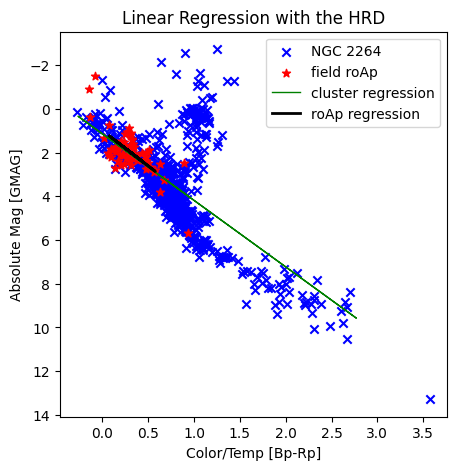

In [25]:
regr = LinearRegression()
regc = LinearRegression()
# Fitting/Training the model
regr.fit(xtrain_r,ytrain_r)
regc.fit(xtrain_c,ytrain_c)
# Predictions
data_r_pred = regr.predict(xtest_r)
data_c_pred = regc.predict(xtest_c)

# The coefficients
print(f"Coefficient for roAp or slope(m) in y = mx+b: {regr.coef_}")
print(f"Coefficient for cluster or slope(m) in y = mx+b: {regc.coef_}")
# The mean squared error
print("\nMean squared error for roAp: %.2f" % mean_squared_error(ytest_r, data_r_pred ))
print("Mean squared error for cluster: %.2f" % mean_squared_error(ytest_c, data_c_pred ))
# The coefficient of determination: 1 is perfect prediction
print("\nCoefficient of determination for roAp: %.2f" % r2_score(ytest_r, data_r_pred ))
print("Coefficient of determination for cluster: %.2f" % r2_score(ytest_c, data_c_pred ))

plt.figure(figsize=(5,5))
plt.title('Linear Regression with the HRD')
plt.scatter(x=xtrain_c,y=ytrain_c,marker='x', c='b', label='NGC 2264')
plt.scatter(x=xtrain_r,y=ytrain_r,marker='*', c='r', label='field roAp')
plt.gca().invert_yaxis()
plt.plot(xtest_c,data_c_pred,c='green',linewidth=1,label='cluster regression')
plt.plot(xtest_r,data_r_pred,c='black',linewidth=2,label='roAp regression')
plt.legend()
plt.ylabel('Absolute Mag [GMAG]')
plt.xlabel('Color/Temp [Bp-Rp]')
plt.savefig('Figures/LinearRegHRD-both')

### 4. Training and plotting the concatenated dataset with the linear regression

Coefficient: or slope(m) in y = mx+b: [1.47011597]

Mean squared error: 2.19

Coefficient of determination: 0.49


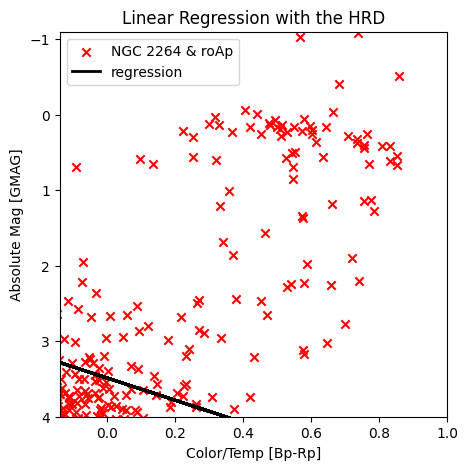

In [26]:
# Calculating the point-density
'''xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]'''

reg = LinearRegression()

# Fitting/Training the model
reg.fit(xtrain,ytrain)
# Predictions
data_y_pred = reg.predict(xtest)

# The coefficients
print(f"Coefficient: or slope(m) in y = mx+b: {reg.coef_}")
# The mean squared error
print("\nMean squared error: %.2f" % mean_squared_error(ytest, data_y_pred ))
# The coefficient of determination: 1 is perfect prediction
print("\nCoefficient of determination: %.2f" % r2_score(ytest, data_y_pred ))

plt.figure(figsize=(5,5))
plt.title('Linear Regression with the HRD')
plt.ylim([-1.1,4])
plt.xlim([-0.14,1])
plt.scatter(xtrain,ytrain,marker='x',c='r',label='NGC 2264 & roAp')
plt.gca().invert_yaxis()
plt.plot(xtest,data_y_pred,c='black',linewidth=2,label='regression')
plt.legend()
plt.ylabel('Absolute Mag [GMAG]')
plt.xlabel('Color/Temp [Bp-Rp]')
plt.savefig('Figures/LinearRegHRD-concat.png')

In [53]:
# For field roAp's
regr.fit(xtrain_r,ytrain_r)

pred = regr.predict(x.reshape(-1,1))
print(regr.coef_)
dist = np.abs(y.reshape(-1,1) - pred)
print(len(dist))

[3.22783172]
1058


In [52]:
print('Stars in NGC 2264 following the regression:')
cands = []
thresh = 1
for n in range(len(all)):
    if dist[n]<thresh:
        cand = clust.iloc[n]['id']
        print('ID:',cand, '--- Gmag:', ytrain[n], '--- B-R: ', xtrain[n])
        cands.append({'ID':cand,'Gmag':ytrain[n],'B-R':xtrain[n]})
        #TO DO: split this plotting up into a separate cell
        plt.gca().invert_yaxis()
        plt.scatter(xtrain[n],ytrain[n],c='r',label='candidates')
        plt.scatter(xtrain_r,ytrain_r,c='b',label='roAp')
        plt.legend()
        plt.show()

Stars in NGC 2264 following the regression:


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()